In [16]:
import warnings
warnings.filterwarnings('ignore')
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import time
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from ploting import *
%matplotlib inline

## Load data

In [2]:
data= pd.read_csv("data/admission.txt",  header=None)

In [3]:
X = data.iloc[:,0:2].as_matrix()
y = data.iloc[:,-1].as_matrix().reshape(-1,1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

## Define model

In [5]:
class Model(torch.nn.Module):

    def __init__(self, nb_input, nb_output):
        """
        In the constructor we instantiate two nn.Linear module
        """
        super(Model, self).__init__()
        self.nb_input = nb_input
        self.nb_output =nb_output
        self.linear = torch.nn.Linear(self.nb_input, self.nb_output)  # One in and one out

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        y_pred = F.sigmoid(self.linear(x))
        return y_pred

## Define prediction function

In [6]:
def predict(x_data, model):
    x_data = torch.from_numpy(x_data).float()
    x_data = Variable(x_data)
    
    if torch.cuda.is_available():
        model = model.cuda()
        x_data = x_data.cuda()
        
    y_pred = model(x_data) 
    
    if torch.cuda.is_available():
        y_pred=y_pred.cpu()
        
         
    return  y_pred.data.numpy()

## Define training function

In [7]:
def model_train(x_data, y_data, model, lrate):
    
    x_data = torch.from_numpy(x_data).float()
    y_data = torch.from_numpy(y_data).float()
    
    x_data = Variable(x_data, requires_grad=False)
    y_data = Variable(y_data, requires_grad=False)
    
    if torch.cuda.is_available():
        model = model.cuda()
        x_data = x_data.cuda()
        y_data = y_data.cuda()
        
    criterion = torch.nn.BCELoss(size_average=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=lrate)
    
    
    Epoch = []
    Loss  = []
    start_time = time.time()
    
    for epoch in range(500):
        y_pred = model(x_data)

    
        loss = criterion(y_pred, y_data)
        Epoch.append(epoch)
        Loss.append(loss.data[0])
    
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    return Epoch, Loss 

## Build Model

In [8]:
nb_input = X_train.shape[1]
nb_output = y_train.shape[1]
model = Model(nb_input, nb_output)

In [9]:
epoch, loss_1 = model_train(X_train, y_train, model, 0.1)
epoch, loss_2 = model_train(X_train, y_train, model, 0.01)
epoch, loss_3 = model_train(X_train, y_train, model, 0.001)

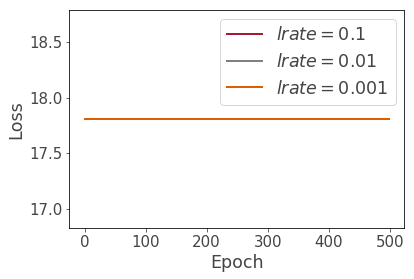

In [10]:
plt.plot(epoch, loss_1, label="$lrate=0.1$")
plt.plot(epoch, loss_2, label="$lrate=0.01$")
plt.plot(epoch, loss_3, label="$lrate=0.001$")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [18]:
pred = predict(X_test, model) 
acc = accuracy_score(y_test, np.around(pred))
fscore = f1_score(y_test, np.around(pred))
print("Model accuracy is {} %".format(acc*100))
print("Model F-Measure is {} %".format(fscore))

Model accuracy is 80.0 %
Model F-Measure is 0.0 %


## Case 2: Normalizing data

In [19]:
def normalize(data):
    row_sums = data.sum(axis=1)
    new_matrix = data / row_sums[:, np.newaxis]
    return new_matrix

In [20]:
X_normal = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X_normal, y, test_size=0.10, random_state=42)

In [21]:
nb_input = X_train.shape[1]
nb_output = y_train.shape[1]
model = Model(nb_input, nb_output)

In [24]:
epoch, loss_1 = model_train(X_train, y_train, model, 0.1)
epoch, loss_2 = model_train(X_train, y_train, model, 0.01)
epoch, loss_3 = model_train(X_train, y_train, model, 0.001)

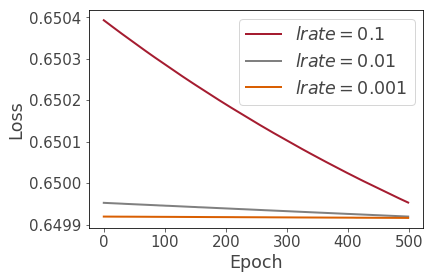

In [25]:
plt.plot(epoch, loss_1, label="$lrate=0.1$")
plt.plot(epoch, loss_2, label="$lrate=0.01$")
plt.plot(epoch, loss_3, label="$lrate=0.001$")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

In [29]:
pred = predict(X_test, model) 
acc = accuracy_score(y_test, np.around(pred))
fscore = f1_score(y_test, np.around(pred))
print("Model accuracy is {} %".format(acc*100))
print("Model F-Measure is {} ".format(round(fscore,2)))

Model accuracy is 20.0 %
Model F-Measure is 0.33 
